In [3]:
#Imports
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
from sympy import *

# Runge's Phenomenon

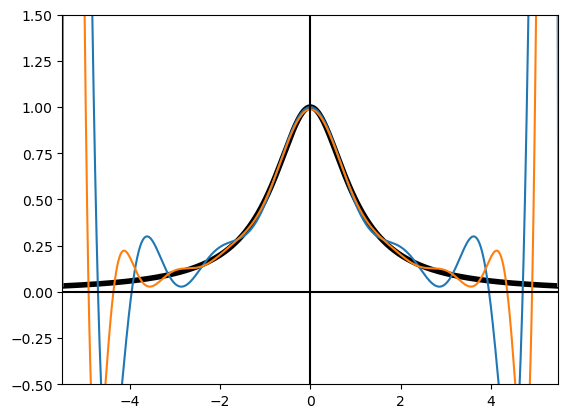

In [23]:
#The problematic function
def runge_func(x):
    return 1/(1+x**2)


def poly_interpolation(n: int, f, cheby: bool = False, a: int = -1, b: int = 1):
    """
    Calcualtes the lagrangian interpolation polynomial of the function f

    Inputs:
    n: Integer which denotes the number of points the polynomial must interpolate
    f: Function which we want to approximate with our polynomial
    cheby: If false we use evenly space points otherwise we use Chebyshev points
    a: The lower extreme of the interval we are interpolating over. Also the first interpolating point
    b: The upper extreme of the interval we are interpolating over. Also the last interpolating point

    Output:
    A function which returns the interpolating polynomial at a point x
    """
    #Data points
    if not cheby:
        #Evenly spaced points if cheby == False
        x_points = np.linspace(a,b,n)
    else:
        #Chebyshev points
        x_points = [(0.5 * (a + b) + 0.5 * (b - a) * np.cos((2*i + 1) * np.pi / (2 * n))) for i in range(n)]

    #The values of the function at the data points
    func = np.vectorize(f)
    y_points = func(x_points)

    #Interpolant polynomial as a function of x
    def interpolant(x):
        #Creating the lagrangian basis
        lagrange_basis = []
        for i in range(n):
            l_i = 1
            #One element of the lagrangian basis
            for j in range(n):
                if j != i:
                    l_i *= (x - x_points[j]) / (x_points[i] - x_points[j])                    
            lagrange_basis.append(l_i)   
        #The value of the interpolating polynomial at x
        return sum([y_points[k] * lagrange_basis[k] for k in range(n)])
    return interpolant

#The figure and some variables
fig, ax = plt.subplots()
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5.5, 5.5])
a = -5
b = 5
extra = 0.5
lower = a - extra
upper = b + extra
res = 1000

#The real function  
exact_vals = [runge_func(t) for t in np.linspace(lower, upper, res)]
ax.plot(np.linspace(lower, upper, res), exact_vals, linewidth=4, color="black")   

#The Lagrangian polynomial interpolation for some values of n
for n in [15, 20]:
    n_th = poly_interpolation(n, runge_func, a = lower, b = upper)
    vals = [n_th(t) for t in np.linspace(lower, upper, res)]
    ax.plot(np.linspace(lower, upper, res), vals)

#x and y axis lines
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
plt.show()

# Using Chebyshev points

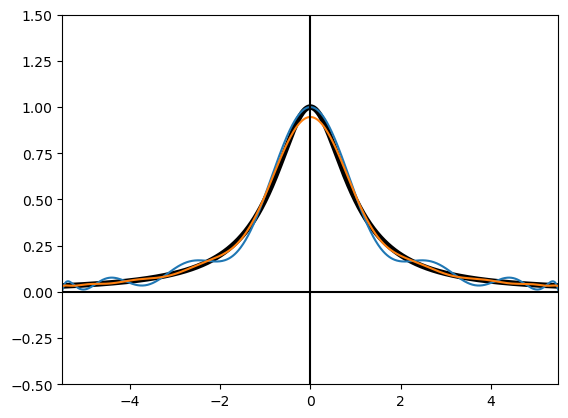

In [5]:
#Using Cheby = True
#The figure and some variables
fig, ax = plt.subplots()
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5.5, 5.5])
a = -5
b = 5
extra = 0.5
lower = a - extra
upper = b + extra
res = 1000

#The real function  
exact_vals = [runge_func(t) for t in np.linspace(lower, upper, res)]
ax.plot(np.linspace(lower, upper, res), exact_vals, linewidth=4, color="black")   

#The Lagrangian polynomial interpolation
for n in [15, 20]:
    n_th = poly_interpolation(n, runge_func, cheby=True, a = lower, b = upper)
    vals = [n_th(t) for t in np.linspace(lower, upper, res)]
    ax.plot(np.linspace(lower, upper, res), vals)

#x and y axis lines
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')

plt.show()

# The Culprit

In [6]:
#A function which gives us the max of the n-th derivative over [-1,1]
def max_nth_derivative(n):
    x = Symbol('x')
    #The Runge function
    y = 1/(1 + x**2)
    #The n-th derivatve
    y_n = y
    i = 0
    while i < n:
        y_n = y_n.diff(x)
        i +=1

    #Creating the function that evaluates the n-th derivative
    f = lambdify(x, y_n, 'numpy')

    #Returning the max over the interval [-1,1]
    return max(f(np.linspace(-1, 1, 2000)))

#Calculating the value of the max of the n-th derivative
n_min = 7
n_max = 20
n_vals = np.linspace(n_min, n_max, n_max - n_min +1)
vals = [max_nth_derivative(n) for n in n_vals]

#A dataframe illustrating the blow up as n increases
df = pd.DataFrame(columns=['n', "max"])
df["n"] = n_vals
df["max"] = vals
df.reset_index(drop=True, inplace=True)
df


,n,max
0,7.0,4.391295e+03
1,8.0,4.031955e+04
2,9.0,3.242556e+05
3,10.0,2.393788e+06
4,11.0,3.629442e+07
5,12.0,4.789907e+08
6,13.0,5.734380e+09
7,14.0,6.391260e+10
8,15.0,1.216009e+12
9,16.0,2.092199e+13


# Solution to the problem

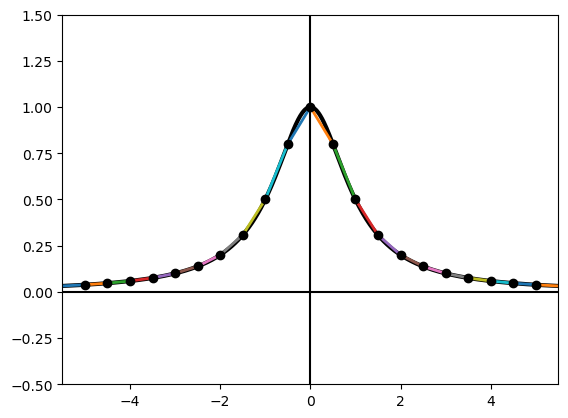

In [25]:
#A function which interpolates on each such interval
def composite_interpolation(n: int, f, a: float, b: float, h: float, res: float):
    """
    A function which calculates the interpolating polynomial on many subintervals of [a,b]

    Inputs:
    n: The number of data points used in interpolating a polynomial over a single subinterval
    f: Function that we are trying to approximate using lagrangian interpolation 
    a: The lower extreme of the interval we are interpolating over. Also the first interpolating point of the first subinterval
    b: The upper extreme of the interval we are interpolating over. Also the last interpolating point of the last subinterval
    h: Size of each subinterval
    res: The resolution of the plots produces

    Output:
    Axes subplot containing all the interpolating polynomials over all the subintervals. I also add the plot of the real function

    """
    #Computing the number of steps and a list of each times step
    numb_steps = int((b - a)//h)+1
    time_steps = [a + j*h for j in range(numb_steps)]

    #Creating the figure
    fig, ax = plt.subplots()

    #The real function plot
    exact_vals = [f(t) for t in np.linspace(a, b, res)]
    ax.plot(np.linspace(a, b, res), exact_vals, linewidth=3, color="black")
    
    #Running over all the subintervals
    for i in range(numb_steps-1):
        #Subdividing each subinterval
        x = np.linspace(time_steps[i], time_steps[i+1], res)

        #Interpolating a polynomial over a single subinterval [time_step[i], time_step[i+1]]
        single_interpolant = poly_interpolation(n, f, False, time_steps[i], time_steps[i+1])

        #The values to plot the interpolating polynomial
        values = [single_interpolant(t) for t in x]

        #Adding the plot
        ax.plot(x, values, linewidth=2)
    return ax

#Some variables used for the plot
n = 2
h = 0.5
a = -5
b = 5
extra = 0.5
lower = a - extra
upper = b + extra
res = 1000

#Calling the function on the variables
ax = composite_interpolation(n, runge_func, lower, upper, h, res)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5.5, 5.5])

#Plotting the data points
numb_steps = int((b - a)//h)+1
time_steps = [a + j*h for j in range(numb_steps)]
y = np.vectorize(runge_func)(time_steps)
ax.plot(time_steps,y,'o', color="black")

#x and y axis lines
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')

plt.show()

# Simpson's method

In [8]:
def simpson(f, a: float, b: float, n: int) -> float:
    """
    Implementation of the Simpson's method for numerical integration.

    Inputs:
    f: A function that takes real inputs and returns real outputs which we would like to integrate
    a: A float acting as the lower extreme of the interval on which we are integrating
    b: A float number acting as the upper extreme of the interval on which we are integrating. Should be strictly large than a
    n: An even natural number strict greater than 1 and counts the number of interval we subdivide the interval [a,b]

    Output:
    A float that is the approximate solution to the integral of f over in interval [a,b]
    """

    #Factors which are multipled by 1
    s1 = f(a) + f(b)
    #Factors which are multipled by 2
    s2 = 0
    #Factors which are multipled by 4
    s4 = 0
    #Grid size
    h = (b-a)/n

    #For loop running over all the grid points
    for i in range(1, n):
        x = a + i * h
        if i % 2 == 1:
            #Odd indices get added to s4
            s4 += f(x)
        else:
            #Even indices get added to s2
            s2 += f(x)
    
    return h/3*(s1 + 4*s4 + 2*s2)


def table_of_approx_simp(f, a, b, real_integral, n_max, step=2):
    """
    Give a dataframe with values in the columns as we vary the values of h

    Inputs:
    f,a,b: Inputs for the simpson function
    real_integral: Real value of the integral we are trying to approximate
    n_max: The largest value that will be added to the table at least greater than 1
    step: Increment to n at each iteration or the number that h gets divided by
    
    Output:
    Dataframe with columns according to the imputs
    """
    
    #Init some lists that we will need to add to the dataframe
    cols = ["n", "h", "S_n", "Errors", "Error_ratio"]
    h_vals = []
    n_vals = []
    S_vals = []
    Error_vals = []
    Error_ratio_vals = []
    count = 0
    #Calcualting the values
    i=step
    while i <= n_max:
        h_vals.append((b-a)/i)
        n_vals.append(i)
        S_vals.append(simpson(f,a,b,i))
        Error_vals.append(abs(real_integral - S_vals[count]))
        #Cannot calculate the very first value
        if count > 0:
            Error_ratio_vals.append(Error_vals[count-1]/Error_vals[count])
        else:
            Error_ratio_vals.append("N.A")
        count += 1
        i *= step
    #The dataframe
    df = pd.DataFrame(columns=cols)
    df["h"] = h_vals
    df["n"] = n_vals
    df["S_n"] = S_vals
    df["Errors"] = Error_vals
    df["Error_ratio"] = Error_ratio_vals 
    df.dropna()
    df.reset_index(drop=True, inplace=True)
    display(df)


In [9]:
#For cubic polynomials the result of Simpson's rule should be exact
def cubic(x):
    return 3*x**3 + 2*x**2 + x + 1

#It is exact!
print("Cubic:", simpson(cubic, 0, 1, 2))


Cubic: 2.9166666666666665


In [10]:
#Simple example with exponential
table_of_approx_simp(np.exp, 0, 1, np.exp(1)-1, 1000,2)

,n,h,S_n,Errors,Error_ratio
0,2,0.500000,1.718861,5.793234e-04,N.A
1,4,0.250000,1.718319,3.701346e-05,15.651695
2,8,0.125000,1.718284,2.326241e-06,15.911277
3,16,0.062500,1.718282,1.455928e-07,15.977714
4,32,0.031250,1.718282,9.102727e-09,15.994422
5,64,0.015625,1.718282,5.689698e-10,15.998612
6,128,0.007812,1.718282,3.556155e-11,15.999575
7,256,0.003906,1.718282,2.222222e-12,16.002698
8,512,0.001953,1.718282,1.383338e-13,16.064205


In [11]:
#Integral of 1/(1+x) over [0,4]
def hyperbola(x):
    return 1/(1+x)

#The table using Simpson's method knowing that the exact value if ln(5)
table_of_approx_simp(hyperbola, 0, 4, np.log(5), 1000,2)

,n,h,S_n,Errors,Error_ratio
0,2,2.000000,1.688889,7.945098e-02,N.A
1,4,1.000000,1.622222,1.278431e-02,6.214726
2,8,0.500000,1.610847,1.408648e-03,9.075586
3,16,0.250000,1.609552,1.144347e-04,12.309631
4,32,0.125000,1.609446,7.841068e-06,14.594269
5,64,0.062500,1.609438,5.031615e-07,15.5836
6,128,0.031250,1.609438,3.166469e-08,15.890304
7,256,0.015625,1.609438,1.982489e-09,15.972191
8,512,0.007812,1.609438,1.239597e-10,15.993005


# Adams-Bashforth method

In [12]:
def AB(f, h: float, t_0: float, t_max: float, y_0: float):
    """
    Returns two lists: 
    The first of the times steps taken along the way
    The second of values that approximate the solution to the initial value problem y'=f(t,y(t)) and y(t_0) = y_0 
    using the Adams-Bashforth of second order

    Inputs:
    f: The function given the the initial value problem that takes two arguments
    h: Step size of discrete time
    t_0: Initial time
    t_max: The maximum time we will consider
    y_0: The value the solution takes at the initial time

    Outputs:
    List of approximate values for the solution to the initial value problem and the time steps taken
    """

    #A list with all the time steps
    numb_steps = int((t_max - t_0)//h)+1
    time_steps = [t_0 + j*h for j in range(0, numb_steps)]

    #List where we are going to store all the values we calculated
    y_sol = np.zeros(len(time_steps))
    y_sol[0] = y_0

    #Calculating the y_sol[1] using Euler's method
    f1 = f(time_steps[0], y_sol[0])
    y_sol[1] = y_sol[0] + h * f1

    #The AB method
    for t in range(2, numb_steps-1):
        f2 = f(time_steps[t], y_sol[t])
        y_sol[t+1] = y_sol[t] + h * 0.5 * (3*f2 - f1)
        f1 = f2
    
    return time_steps, y_sol


# Runge-Kutta of fourth order

In [13]:
def RK4(f, h: float, t_0: float, t_max: float, y_0: float) -> (list, list):
    """
    Returns two lists: 
    The first of the times steps taken along the way
    The second of values that approximate the solution to the initial value problem y'=f(t,y(t)) and y(t_0) = y_0 
    using the Runge-Kutta method of fourth order
    
    Inputs:
    f: The function given the the initial value problem that takes two arguments
    h: Step size of discrete time
    t_0: Initial time
    t_max: The maximum time we will consider
    y_0: The value the solution takes at the initial time 

    Outputs:
    List of approximate values for the solution to the initial value problem and the time steps taken
    """
    #A list with all the time steps
    numb_steps = int((t_max - t_0)//h)+1
    time_steps = [t_0 + j*h for j in range(0, numb_steps)]

    #List where we are going to store all the values we calculated
    y_sol = np.zeros(len(time_steps))

    y_sol[0] = y_0
    for t in range(0, numb_steps-1):
        #K_1 and the intermediate value using k_1 slope
        k_1 = f(time_steps[t], y_sol[t])
        y_1 = y_sol[t] + k_1 * h/2

        #K_2 and the intermediate value using k_2 slope
        k_2 = f(time_steps[t] + 0.5 * h, y_1)
        y_2 = y_sol[t] + k_2 * h/2

        #K_3 and the intermediate value using k_3 slope
        k_3 = f(time_steps[t] + 0.5 * h, y_2)
        y_3 = y_sol[t] + k_3 * h

        #K_4 and the intermediate value using k_4 slope
        k_4 = f(time_steps[t] + h, y_3)

        y_sol[t+1] = y_sol[t] + (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6

    return time_steps, y_sol

    

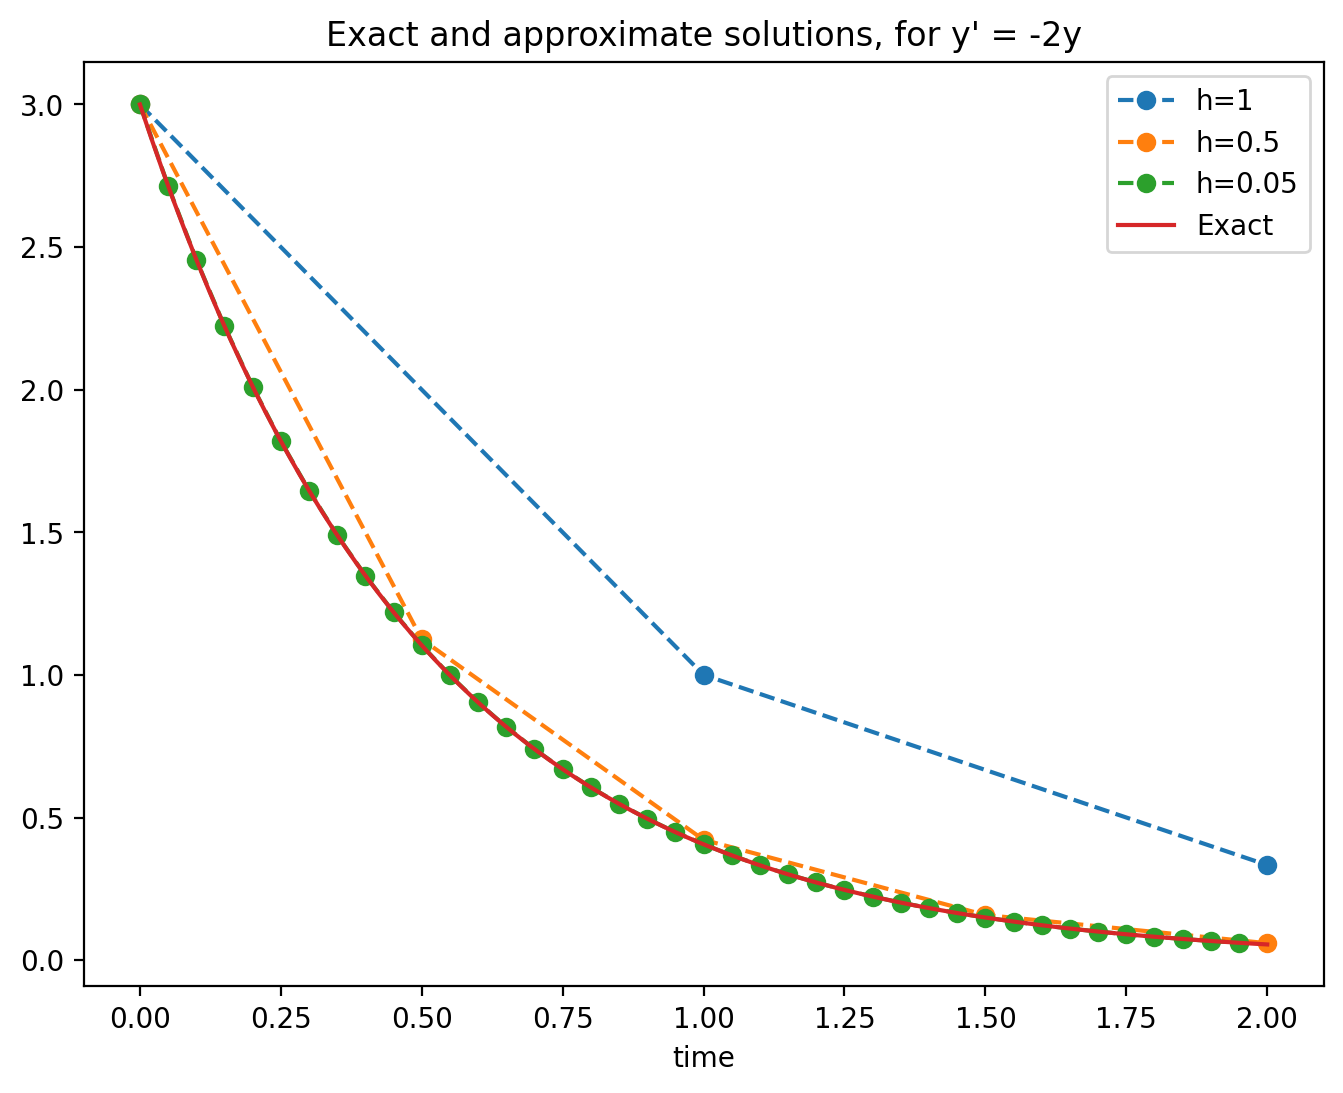

In [14]:
#RHS of differential equation
def simple_ODE(t: float, y: float):
    return -2*y

y_0 = 3.0
t_0 = 0.0
t_max = 2.0

#For IVP that I will tackle there is always a exact solution
def exact_solution(t):
    return 3*np.exp(-2*t)

#The figure
fig, ax = plt.subplots(figsize=(8,6), dpi=200)

#Plotting the various the approximate solution with h = 1
h_1 = 1
x_1, y_1 = RK4(simple_ODE, h_1, t_0, t_max, y_0)
ax.plot(x_1, y_1, 'o--')

#Plotting the various the approximate solution with h = 0.5
h_2 = 0.5
x_2, y_2 = RK4(simple_ODE, h_2, t_0, t_max, y_0)
ax.plot(x_2, y_2, 'o--')

#Plotting the various the approximate solution with h = 0.05
h_3 = 0.05
x_3, y_3 = RK4(simple_ODE, h_3, t_0, t_max, y_0)
ax.plot(x_3, y_3, 'o--')

#Plot the function that is an exact solution to our IVP
exact_vals = [exact_solution(t) for t in np.linspace(t_0, t_max, 100)]
ax.plot(np.linspace(t_0, t_max, 100), exact_vals)

#Adding the legend
ax.legend(["h=1", "h=0.5", "h=0.05", "Exact"])
plt.xlabel("time")
plt.title("Exact and approximate solutions, for y' = -2y")
ax.autoscale()
fig.savefig("RK4 example")
plt.show()

# The stiff differential equation

In [15]:
#Definite the function that corresponds to the differential equation y'= Ay where A can be a complex number
def stiff(t: float, y: float, A_real: float, A_img: float):
    return complex(A_real, A_img) * y

print(stiff(0, 5, 3, 4))

(15+20j)


# Absolute stability regions

For any linear multistep method to find the stability regions we need to plot the values of z for which the stability polynomial satisfies the root conditions. So given all the coefficents of a generic stability polynomial we can plot the stability region for any linear multistep methos with the following code.

In [16]:
#A simple function that multiplies an array and a complex number
def array_times_complex(l,z):
    res = []
    for i in range(len(l)):
        res.append(l[i] * z)
    return res



#A function that returns a function used to evaluate the stability polynomial in each z
def stability_polynomial_z(a:list, b:list):
    n = len(a)
    if len(b) != n:
        raise ValueError("The two lists should have the same length")
    
    #Returns the largest norm amoung the roots of the stability polynomial
    def norms_of_roots(z):
        stability_polynomial = [x - y for x, y in zip(a, array_times_complex(b,z))]
        return np.max(np.abs(np.roots(stability_polynomial)))
    
    #We vectorize the function so we can input directs all the values of z in the plane at once
    return np.vectorize(norms_of_roots)



def stability_region(a: list, b: list, title:str = "Stability Region", res: int = 50, high_lim: int = 2, low_lim: int = -2):
    """
    A function that plots the stability region in the complex plane

    Inputs:
    a: list of alpha values for the stability polynomial
    b: list of beta values for the stability polynomial
    title: Title to put on the plot
    res: The number intervals for the x and y axis
    high_lim: The upper limit for the x and y axis
    low_lim: The lower limit for the x and y axis

    Output: A contour plot that illustrates the values of z which satisfy the root conditions of the stability polynomial
    """

    #Setting up the complex plane
    spacing = np.linspace(low_lim,high_lim,res)
    x_mesh, y_mesh = np.meshgrid(spacing,spacing)
    z_mesh = x_mesh + 1j * y_mesh
    
    #The stability polynomial as a function of z
    poly_z = stability_polynomial_z(a, b)

    #Plotting the contour plot that fills the region where the stability polynomial satisfies the root conditions
    fig, ax = plt.subplots(figsize=(6,6))
    ax.contourf(x_mesh, y_mesh, poly_z(z_mesh), [0,1], colors=["gray"])
    ax.contour(x_mesh, y_mesh, poly_z(z_mesh), [1], colors=["black"])
    ax.set_title(title)
    plt.xlabel("Real")
    plt.ylabel("Imaginary")

    #x and y axis lines
    plt.axhline(y=0, color='black', linestyle='-')
    plt.axvline(x=0, color='black', linestyle='-')
    

    #Save the image
    image_name = str("Stab region of " + title)
    fig.savefig(image_name)
    
    plt.grid()
    plt.show()


## Stability region for Trapezoidal method

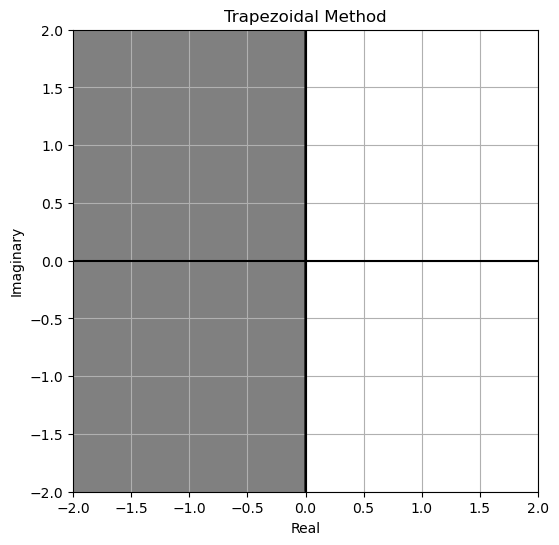

In [17]:
#Stability region for trapezoidal method
stability_region([1,-1], [1/2,1/2], "Trapezoidal Method")

## Stability Region for Euler methods

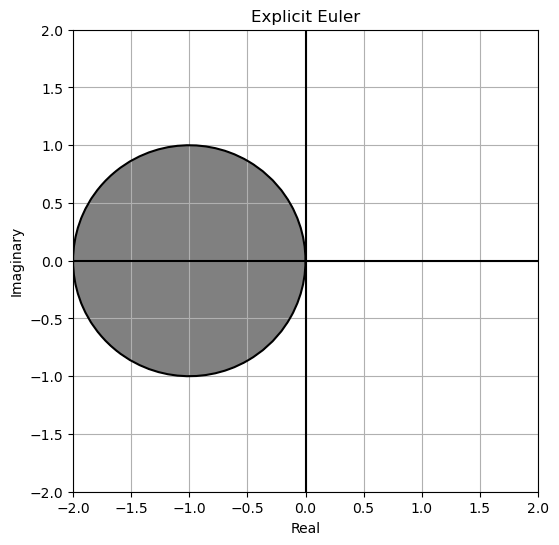

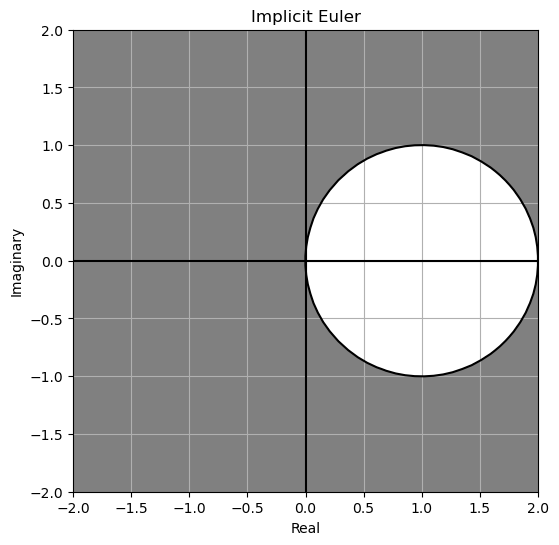

In [18]:
#Stability region for explicit Euler
stability_region([1,-1], [0,1], "Explicit Euler")


#Stability region for implicit Euler
stability_region([1,-1], [1,0], "Implicit Euler")

## Stability region for Adams-Bashforth methods

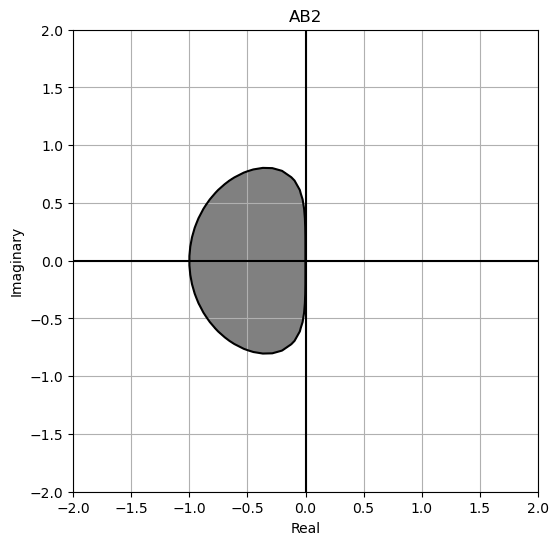

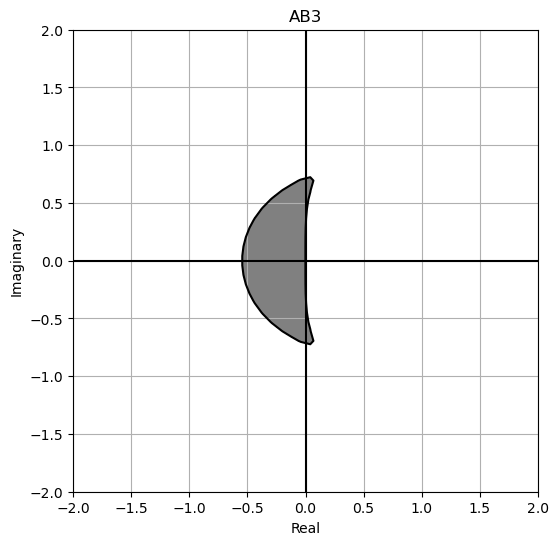

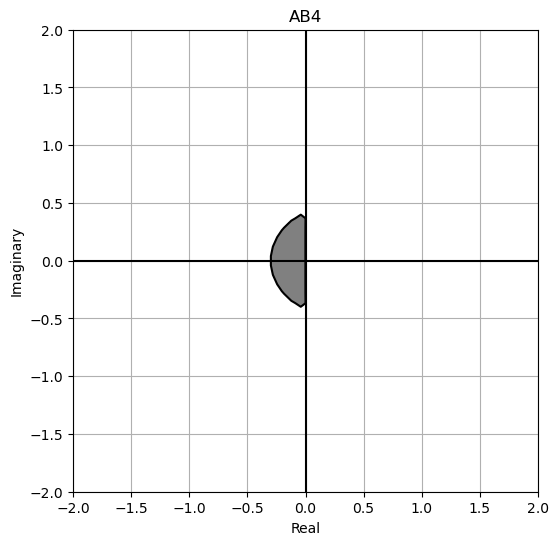

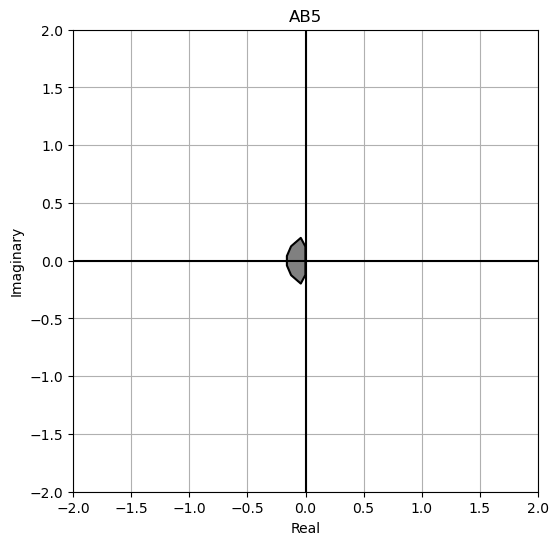

In [19]:
#I skip AB1 as it is identical to explicit Euler
#Stability region for AB2
stability_region([1,-1, 0], [0, 3/2, -1/2], "AB2")

#Stability region for AB3
stability_region([1,-1, 0, 0], [0, 23/12, -16/12, 5/12], "AB3")

#Stability region for AB4
stability_region([1,-1, 0, 0, 0], [0, 55/24, -59/24, 37/24, -9/24], "AB4")

#Stability region for AB5
stability_region([1,-1, 0, 0, 0, 0], [0, 1901/720,-2774/720, 2616/720, -1274/720, 251/720], "AB5")
